Using device: cuda
FCNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=84, bias=True)
    (5): Tanh()
    (6): Linear(in_features=84, out_features=84, bias=True)
    (7): Tanh()
    (8): Linear(in_features=84, out_features=1, bias=True)
  )
)
Total parameters: 21757
[Adam] Epoch      1 | Loss = 1.0520e+02 | L_int = 1.0023e+02 | L_bc = 4.9689e+00
[Adam] Epoch    500 | Loss = 4.4978e-01 | L_int = 3.3967e-01 | L_bc = 1.1011e-01
[Adam] Epoch   1000 | Loss = 2.5914e-02 | L_int = 1.1413e-02 | L_bc = 1.4501e-02
[Adam] Epoch   1500 | Loss = 6.5633e-03 | L_int = 3.1966e-03 | L_bc = 3.3666e-03
[Adam] Epoch   2000 | Loss = 4.3126e-03 | L_int = 2.2798e-03 | L_bc = 2.0328e-03
[Adam] Epoch   2500 | Loss = 7.6496e-03 | L_int = 5.6929e-03 | L_bc = 1.9567e-03
[Adam] Epoch   3000 | Loss = 1.7568e-01 | L_int = 1.6994e-01 | L_bc = 5.742

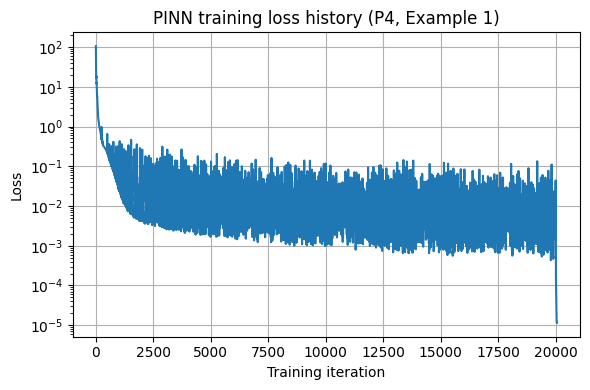

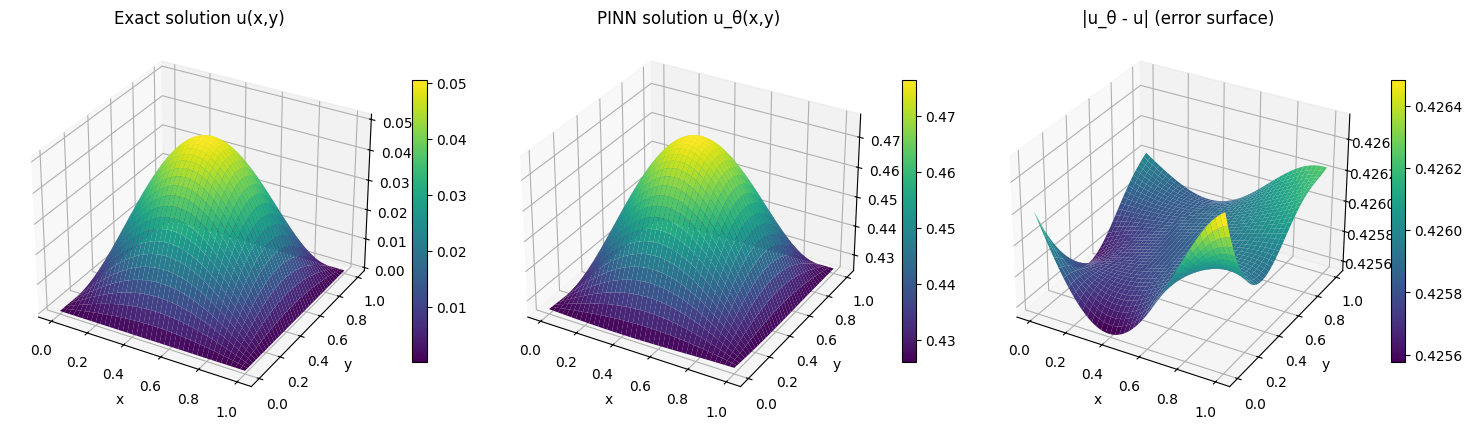

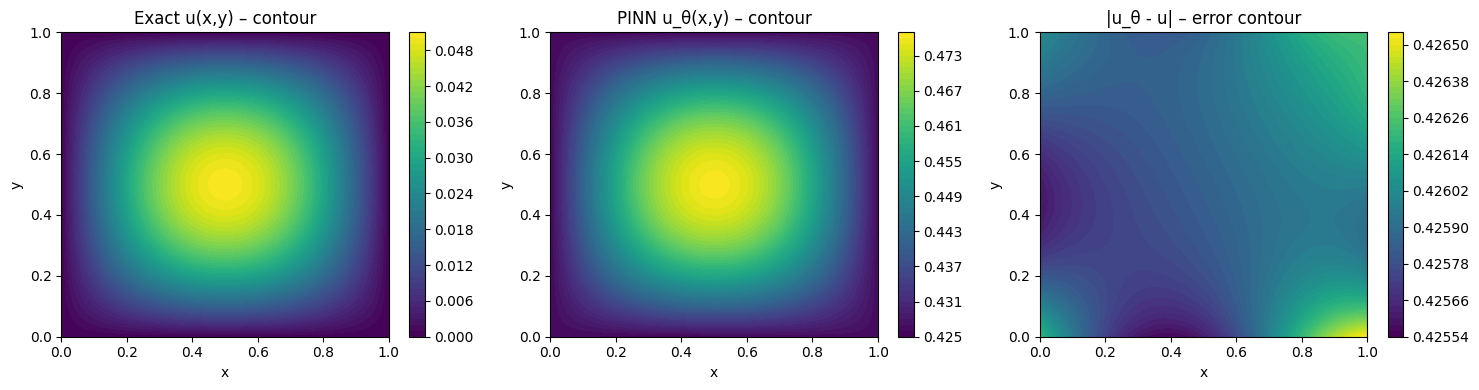

Neural network architecture: FCNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=84, bias=True)
    (5): Tanh()
    (6): Linear(in_features=84, out_features=84, bias=True)
    (7): Tanh()
    (8): Linear(in_features=84, out_features=1, bias=True)
  )
)
Training parameters:
  SEED                  = 42
  N_INT (interior)      = 10000
  N_EDGE (per edge)     = 2000
  total boundary points = 8000
  LAYERS                = [2, 84, 84, 84, 84, 1]
  LR_ADAM               = 0.001
  ADAM_EPOCHS           = 20000
  LR_LBFGS              = 1.0
  LBFGS_STEPS           = 50
  LAMBDA_INT            = 1.0
  LAMBDA_BC             = 1.0
  GRID_N                = 81
  Total parameters      = 21757
  Total training time   = 3349.62 sec


In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ======================================================================
# HYPERPARAMETERS (TUNE HERE)
# ======================================================================
SEED            = 42            # random seed
N_INT           = 10000          # number of interior collocation points
N_EDGE          = 2000          # boundary points per edge (total = 4 * N_EDGE)
GRID_N          = 81            # grid size for error evaluation / plots

LAYERS          = [2, 84, 84, 84, 84, 1]   # NN architecture
ACTIVATION      = nn.Tanh()     # activation function (for hidden layers)

LR_ADAM         = 1e-3          # Adam learning rate
ADAM_EPOCHS     = 20000         # Adam epochs
LR_LBFGS        = 1.0           # LBFGS learning rate
LBFGS_STEPS     = 50            # number of outer LBFGS steps

LAMBDA_INT      = 1.0           # weight for interior PDE residual
LAMBDA_BC       = 1.0           # weight for total P4 boundary loss

PRINT_EVERY     = 500           # how often to print during Adam

# ======================================================================
# GLOBAL SETUP
# ======================================================================
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(SEED)
np.random.seed(SEED)

pi = torch.pi

# ======================================================================
# Exact solution and PDE data for Example 1 (P4 BCs)
#   u(x,y) = 1/(2π²) sin(πx) sin(πy)
#   Δ²u = 2π² sin(πx) sin(πy)
# ======================================================================

def u_exact_xy(x, y):
    """Exact solution u(x,y). x,y are tensors on the same device."""
    return (1.0 / (2.0 * pi**2)) * torch.sin(pi * x) * torch.sin(pi * y)

def f_rhs_xy(x, y):
    """Right-hand side f(x,y) = Δ²u."""
    return 2.0 * pi**2 * torch.sin(pi * x) * torch.sin(pi * y)

# ======================================================================
# PINN model
# ======================================================================

class FCNet(nn.Module):
    def __init__(self, layers, activation=nn.Tanh()):
        super().__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                layer_list.append(activation)
        self.net = nn.Sequential(*layer_list)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# ======================================================================
# Automatic differentiation helpers (ALL derivatives via autograd)
# ======================================================================

def laplacian(u, x):
    """
    Compute Laplacian Δu for scalar field u(x) with x in R^2.
    u: (N, 1) tensor
    x: (N, 2) tensor with requires_grad=True
    Returns: (N, 1) tensor
    """
    grad_u = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]  # (N, 2)
    lap = torch.zeros_like(u)
    for i in range(x.shape[1]):
        grad_ui = grad_u[:, i:i+1]
        grad2_ui = torch.autograd.grad(
            grad_ui,
            x,
            grad_outputs=torch.ones_like(grad_ui),
            create_graph=True
        )[0][:, i:i+1]
        lap = lap + grad2_ui
    return lap

def biharmonic(u, x):
    """
    Compute biharmonic operator Δ²u = Δ(Δu).
    """
    lap_u = laplacian(u, x)
    bih = laplacian(lap_u, x)
    return bih

def normal_derivative(u, x, normals):
    """
    Compute normal derivative ∂u/∂n = ∇u · n
    u: (N, 1), x: (N, 2) (requires_grad=True), normals: (N, 2)
    Returns: (N, 1)
    """
    grad_u = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]  # (N, 2)
    nd = torch.sum(grad_u * normals, dim=1, keepdim=True)
    return nd

def normal_derivative_of_laplacian(u, x, normals):
    """
    Compute ∂(Δu)/∂n = ∇(Δu) · n
    """
    lap_u = laplacian(u, x)
    grad_lap = torch.autograd.grad(
        lap_u, x, grad_outputs=torch.ones_like(lap_u), create_graph=True
    )[0]  # (N, 2)
    nd_lap = torch.sum(grad_lap * normals, dim=1, keepdim=True)
    return nd_lap

# ======================================================================
# Collocation points: interior and boundary for P4 (Cahn–Hilliard BCs)
# ======================================================================

def generate_interior_points(N_int):
    # Uniform sampling in (0,1)^2
    x = torch.rand(N_int, 1, device=device)
    y = torch.rand(N_int, 1, device=device)
    X_int = torch.cat([x, y], dim=1)
    X_int.requires_grad_(True)
    return X_int

def generate_boundary_points(N_edge):
    """
    Generate boundary points and corresponding normals and exact BC values
    for P4:
        ∂u/∂n = g1,  ∂Δu/∂n = g2 on ∂Ω.
    All derivatives for g1, g2 are computed with autograd.
    """
    # Left: x=0, y in (0,1), n = (-1,0)
    yL = torch.rand(N_edge, 1, device=device)
    xL = torch.zeros_like(yL, device=device)
    XL = torch.cat([xL, yL], dim=1)
    nL = torch.tensor([-1.0, 0.0], device=device).repeat(N_edge, 1)

    # Right: x=1, y in (0,1), n = (1,0)
    yR = torch.rand(N_edge, 1, device=device)
    xR = torch.ones_like(yR, device=device)
    XR = torch.cat([xR, yR], dim=1)
    nR = torch.tensor([1.0, 0.0], device=device).repeat(N_edge, 1)

    # Bottom: y=0, x in (0,1), n = (0,-1)
    xB = torch.rand(N_edge, 1, device=device)
    yB = torch.zeros_like(xB, device=device)
    XB = torch.cat([xB, yB], dim=1)
    nB = torch.tensor([0.0, -1.0], device=device).repeat(N_edge, 1)

    # Top: y=1, x in (0,1), n = (0,1)
    xT = torch.rand(N_edge, 1, device=device)
    yT = torch.ones_like(xT, device=device)
    XT = torch.cat([xT, yT], dim=1)
    nT = torch.tensor([0.0, 1.0], device=device).repeat(N_edge, 1)

    X_bd = torch.cat([XL, XR, XB, XT], dim=0)
    normals = torch.cat([nL, nR, nB, nT], dim=0)

    # Enable gradients for BC derivative computation
    X_bd.requires_grad_(True)

    # Exact solution on boundary
    u_ex_bd = u_exact_xy(X_bd[:, 0:1], X_bd[:, 1:2])

    # g1 = ∂u/∂n (via autograd)
    grad_u_ex_bd = torch.autograd.grad(
        u_ex_bd, X_bd, grad_outputs=torch.ones_like(u_ex_bd), create_graph=True
    )[0]  # (N_bd, 2)
    g1 = torch.sum(grad_u_ex_bd * normals, dim=1, keepdim=True).detach()

    # g2 = ∂(Δu)/∂n (via autograd + laplacian helper)
    lap_u_ex_bd = laplacian(u_ex_bd, X_bd)
    grad_lap_ex_bd = torch.autograd.grad(
        lap_u_ex_bd, X_bd, grad_outputs=torch.ones_like(lap_u_ex_bd), create_graph=True
    )[0]
    g2 = torch.sum(grad_lap_ex_bd * normals, dim=1, keepdim=True).detach()

    return X_bd, normals, g1, g2

# ======================================================================
# Build dataset
# ======================================================================

X_int = generate_interior_points(N_INT)
X_bd, normals_bd, g1_bd, g2_bd = generate_boundary_points(N_EDGE)

# ======================================================================
# Instantiate PINN
# ======================================================================

model = FCNet(LAYERS, activation=ACTIVATION).to(device)
print(model)
n_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {n_params}")

# ======================================================================
# Loss and optimizer
# ======================================================================

mse_loss = nn.MSELoss()

def pinn_loss():
    # Interior loss: Δ²u = f
    u_int   = model(X_int)                    # (N_int, 1)
    bih_int = biharmonic(u_int, X_int)        # (N_int, 1)
    f_int   = f_rhs_xy(X_int[:, 0:1], X_int[:, 1:2])
    L_int   = mse_loss(bih_int, f_int)

    # Boundary loss (single L_bc, as in PDF P4):
    # L_bc = mean( |∂n uθ - g1|^2 + |∂n Δuθ - g2|^2 )
    u_bd    = model(X_bd)                     # (N_bd, 1)
    du_dn   = normal_derivative(u_bd, X_bd, normals_bd)
    dlap_dn = normal_derivative_of_laplacian(u_bd, X_bd, normals_bd)

    L_bc_u   = mse_loss(du_dn,  g1_bd)
    L_bc_lap = mse_loss(dlap_dn, g2_bd)
    L_bc     = L_bc_u + L_bc_lap

    loss    = LAMBDA_INT * L_int + LAMBDA_BC * L_bc
    return loss, L_int, L_bc

optimizer_adam = optim.Adam(model.parameters(), lr=LR_ADAM)
optimizer_lbfgs = optim.LBFGS(
    model.parameters(),
    lr=LR_LBFGS,
    max_iter=100,
    max_eval=200,
    history_size=50,
    line_search_fn="strong_wolfe"
)

loss_history = []

# ======================================================================
# Training
# ======================================================================

t0 = time.time()

# --- Adam phase ---
for epoch in range(1, ADAM_EPOCHS + 1):
    optimizer_adam.zero_grad()
    loss, L_int, L_bc = pinn_loss()
    loss.backward()
    optimizer_adam.step()

    loss_history.append(loss.item())

    if epoch % PRINT_EVERY == 0 or epoch == 1:
        print(f"[Adam] Epoch {epoch:6d} | "
              f"Loss = {loss.item():.4e} | "
              f"L_int = {L_int.item():.4e} | "
              f"L_bc = {L_bc.item():.4e}")

# --- LBFGS refinement ---
def closure():
    optimizer_lbfgs.zero_grad()
    loss, L_int, L_bc = pinn_loss()
    loss.backward()
    return loss

print("Starting LBFGS refinement...")
for i in range(LBFGS_STEPS):
    _ = optimizer_lbfgs.step(closure)
    loss, L_int, L_bc = pinn_loss()
    loss_history.append(loss.item())
    print(f"[LBFGS] Step {i+1:3d} | Loss = {loss.item():.4e} | "
          f"L_int = {L_int.item():.4e} | "
          f"L_bc = {L_bc.item():.4e}")

t1 = time.time()
train_time = t1 - t0
print(f"Total training time: {train_time:.2f} seconds")

# ======================================================================
# Error evaluation on a uniform grid (all derivatives via autograd)
# Uses *relative* energy errors as in the PDF:
#  L2_rel   = ||e||_L2 / ||u||_L2
#  H1_rel   = (||e||_L2 + ||∇e||_L2) / (||u||_L2 + ||∇u||_L2)
#  H2_rel   = (||e||_L2 + ||∇e||_L2 + ||Δe||_L2) / (||u||_L2 + ||∇u||_L2 + ||Δu||_L2)
# ======================================================================

x_lin = torch.linspace(0.0, 1.0, GRID_N, device=device)
y_lin = torch.linspace(0.0, 1.0, GRID_N, device=device)  # <-- FIXED: added GRID_N
Xg, Yg = torch.meshgrid(x_lin, y_lin, indexing="ij")
XY_base = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)

# Predicted solution with autograd-enabled coords
XY_pred = XY_base.clone().detach().requires_grad_(True)
u_pred  = model(XY_pred)

# Exact solution with autograd-enabled coords
XY_ex = XY_base.clone().detach().requires_grad_(True)
u_ex  = u_exact_xy(XY_ex[:, 0:1], XY_ex[:, 1:2])

# Error field
e = u_pred - u_ex

# --- L2 norms ---
mean_e2  = torch.mean(e**2)
mean_u2  = torch.mean(u_ex**2)
L2_err_abs   = torch.sqrt(mean_e2)
L2_exact_abs = torch.sqrt(mean_u2)
L2_err_rel   = (L2_err_abs / L2_exact_abs).item()

# --- Gradients ---
grad_u_pred = torch.autograd.grad(
    u_pred, XY_pred, grad_outputs=torch.ones_like(u_pred), create_graph=True
)[0]
ux_pred = grad_u_pred[:, 0:1]
uy_pred = grad_u_pred[:, 1:2]

grad_u_ex = torch.autograd.grad(
    u_ex, XY_ex, grad_outputs=torch.ones_like(u_ex), create_graph=True
)[0]
ux_ex = grad_u_ex[:, 0:1]
uy_ex = grad_u_ex[:, 1:2]

ex_x = ux_pred - ux_ex
ex_y = uy_pred - uy_ex

mean_grad_e2 = torch.mean(ex_x**2 + ex_y**2)
mean_grad_u2 = torch.mean(ux_ex**2 + uy_ex**2)
grad_err_abs   = torch.sqrt(mean_grad_e2)
grad_exact_abs = torch.sqrt(mean_grad_u2)

# --- Laplacians ---
lap_pred = laplacian(u_pred, XY_pred)
lap_ex   = laplacian(u_ex,   XY_ex)
e_lap    = lap_pred - lap_ex

mean_lap_e2 = torch.mean(e_lap**2)
mean_lap_u2 = torch.mean(lap_ex**2)
lap_err_abs   = torch.sqrt(mean_lap_e2)
lap_exact_abs = torch.sqrt(mean_lap_u2)

# --- Energy-style relative errors ---
H1_energy_err   = L2_err_abs + grad_err_abs
H1_energy_exact = L2_exact_abs + grad_exact_abs
H1_err_rel      = (H1_energy_err / H1_energy_exact).item()

H2_energy_err   = L2_err_abs + grad_err_abs + lap_err_abs
H2_energy_exact = L2_exact_abs + grad_exact_abs + lap_exact_abs
H2_err_rel      = (H2_energy_err / H2_energy_exact).item()

print("Relative error metrics (as in PDF):")
print(f"  L2  relative error        ≈ {L2_err_rel:.4e}")
print(f"  H1  energy relative error ≈ {H1_err_rel:.4e}")
print(f"  H2  energy relative error ≈ {H2_err_rel:.4e}")

print("Absolute norms (for reference):")
print(f"  ||e||_L2      ≈ {L2_err_abs.item():.4e}")
print(f"  ||∇e||_L2     ≈ {grad_err_abs.item():.4e}")
print(f"  ||Δe||_L2     ≈ {lap_err_abs.item():.4e}")

# ======================================================================
# Plotting
# ======================================================================

# Convert to numpy grids
u_ex_grid   = u_ex.detach().cpu().numpy().reshape(GRID_N, GRID_N)
u_pred_grid = u_pred.detach().cpu().numpy().reshape(GRID_N, GRID_N)
err_grid    = u_pred_grid - u_ex_grid
abs_err_grid = np.abs(err_grid)

Xg_np = Xg.detach().cpu().numpy()
Yg_np = Yg.detach().cpu().numpy()

# 1) Loss history (training dynamics)
plt.figure(figsize=(6, 4))
plt.semilogy(loss_history, '-')
plt.xlabel("Training iteration")
plt.ylabel("Loss")
plt.title("PINN training loss history (P4, Example 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) 3D surfaces with colour depth
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
surf1 = ax1.plot_surface(Xg_np, Yg_np, u_ex_grid, cmap='viridis', linewidth=0, antialiased=True)
ax1.set_title("Exact solution u(x,y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(surf1, ax=ax1, shrink=0.6)

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
surf2 = ax2.plot_surface(Xg_np, Yg_np, u_pred_grid, cmap='viridis', linewidth=0, antialiased=True)
ax2.set_title("PINN solution u_θ(x,y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(surf2, ax=ax2, shrink=0.6)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
surf3 = ax3.plot_surface(Xg_np, Yg_np, abs_err_grid, cmap='viridis', linewidth=0, antialiased=True)
ax3.set_title("|u_θ - u| (error surface)")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
fig.colorbar(surf3, ax=ax3, shrink=0.6)

plt.tight_layout()
plt.show()

# 3) 2D contour plots (colour maps)
fig2, axs = plt.subplots(1, 3, figsize=(15, 4))

cs0 = axs[0].contourf(Xg_np, Yg_np, u_ex_grid, levels=50)
axs[0].set_title("Exact u(x,y) – contour")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
fig2.colorbar(cs0, ax=axs[0])

cs1 = axs[1].contourf(Xg_np, Yg_np, u_pred_grid, levels=50)
axs[1].set_title("PINN u_θ(x,y) – contour")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
fig2.colorbar(cs1, ax=axs[1])

cs2 = axs[2].contourf(Xg_np, Yg_np, abs_err_grid, levels=50)
axs[2].set_title("|u_θ - u| – error contour")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
fig2.colorbar(cs2, ax=axs[2])

plt.tight_layout()
plt.show()

print("Neural network architecture:", model)
print("Training parameters:")
print(f"  SEED                  = {SEED}")
print(f"  N_INT (interior)      = {N_INT}")
print(f"  N_EDGE (per edge)     = {N_EDGE}")
print(f"  total boundary points = {4 * N_EDGE}")
print(f"  LAYERS                = {LAYERS}")
print(f"  LR_ADAM               = {LR_ADAM}")
print(f"  ADAM_EPOCHS           = {ADAM_EPOCHS}")
print(f"  LR_LBFGS              = {LR_LBFGS}")
print(f"  LBFGS_STEPS           = {LBFGS_STEPS}")
print(f"  LAMBDA_INT            = {LAMBDA_INT}")
print(f"  LAMBDA_BC             = {LAMBDA_BC}")
print(f"  GRID_N                = {GRID_N}")
print(f"  Total parameters      = {n_params}")
print(f"  Total training time   = {train_time:.2f} sec")


Using device: cuda

Network:
 BiharmonicPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1-3): 3 x Linear(in_features=84, out_features=84, bias=True)
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
  (activation): Tanh()
)

Total parameters: 21757

Computing f(x)=Δ²u_exact and (g1,g2) on collocation points...

====================== Adam training (P4, Example 3.1, Option B) ======================

[Adam] Epoch      1 | LR: 1.000e-03 | Loss = 3.4430e+02 | L_int = 9.6925e+01 | L_bc = 4.9475e+00
[Adam] Epoch    500 | LR: 1.000e-03 | Loss = 1.3382e-01 | L_int = 9.4721e-02 | L_bc = 7.8200e-04
[Adam] Epoch   1000 | LR: 1.000e-03 | Loss = 5.7940e-02 | L_int = 3.9406e-02 | L_bc = 3.7068e-04
[Adam] Epoch   1500 | LR: 1.000e-03 | Loss = 3.6504e-02 | L_int = 2.3616e-02 | L_bc = 2.5776e-04
[Adam] Epoch   2000 | LR: 1.000e-03 | Loss = 6.8748e-02 | L_int = 3.0249e-02 | L_bc = 7.6998e-04
[Adam] Epoch   2500 | LR: 1.000e-03 | Loss = 1.8028e-0

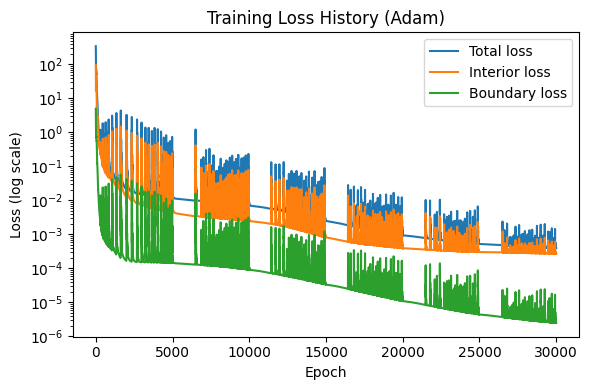

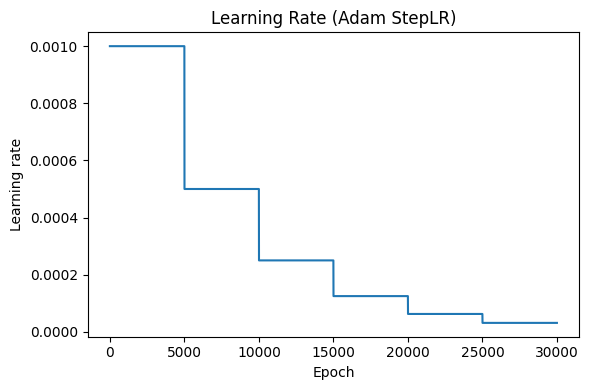

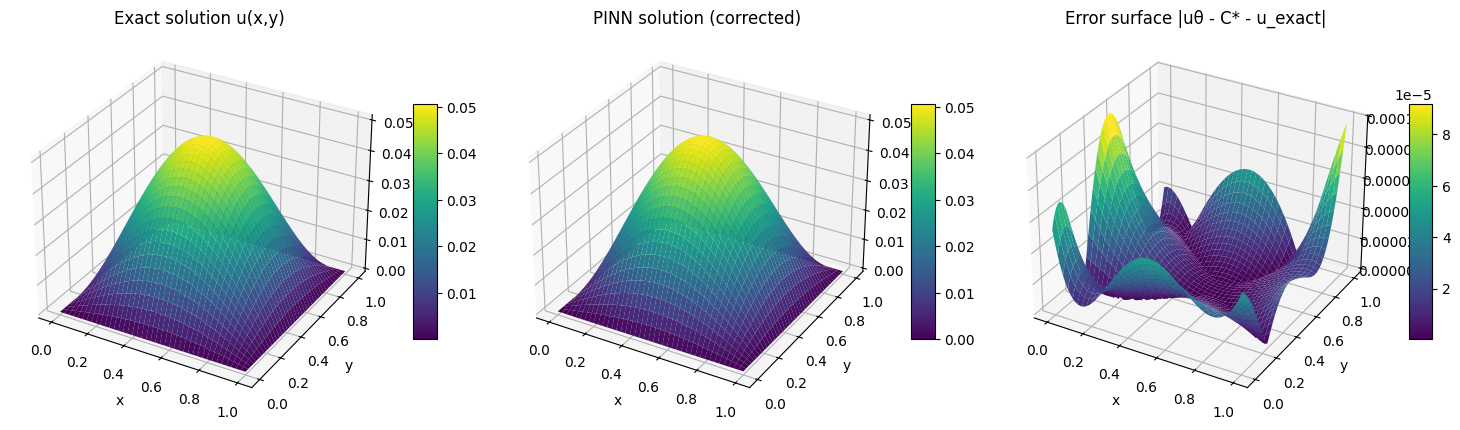

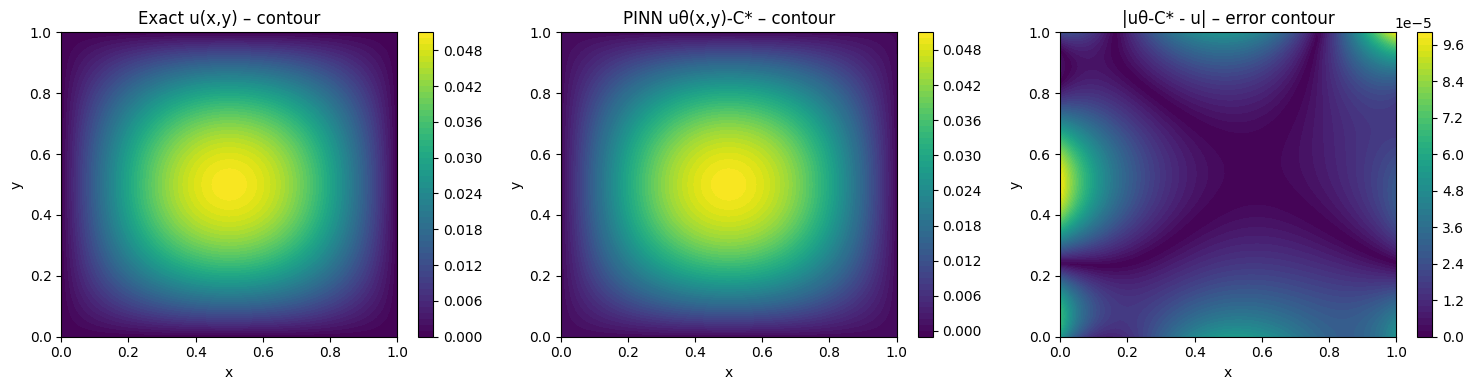


All results (plots + models) saved in: p4_example1_optionB_results

Network: BiharmonicPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1-3): 3 x Linear(in_features=84, out_features=84, bias=True)
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
  (activation): Tanh()
)
Training parameters:
  SEED               = 42
  N_INT              = 9000
  N_BD_PER_EDGE      = 1000  (total boundary points = 4000)
  LAMBDA_INT         = 1.0
  LAMBDA_BC          = 50.0
  MAX_EPOCHS_ADAM    = 30000
  USE_LBFGS          = True
  LBFGS_STEPS        = 50
  GRID_N             = 81
  Total parameters   = 21757
  Total training time= 10037.32 seconds


In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =============================================================================
# HYPERPARAMETERS (TUNE HERE, ALL IN ONE BLOCK)
# =============================================================================
OUT_DIR          = "p4_example1_optionB_results"
SEED             = 42
TORCH_DTYPE      = torch.float64

# Collocation points
N_INT            = 9000          # interior points
N_BD_PER_EDGE    = 1000          # boundary points per edge (total boundary = 4 * N_BD_PER_EDGE)

# Loss weights
LAMBDA_INT       = 1.0           # weight for interior PDE residual
LAMBDA_BC        = 50.0           # weight for P4 BCs (g1 + g2)

# Adam stage
MAX_EPOCHS_ADAM  = 30000         # <--- increased to 30000
TARGET_LOSS      = 1e-5          # optional early-stop target
LOG_EVERY        = 500

INIT_LR          = 1e-3
STEP_SIZE_LR     = 5000
GAMMA_LR         = 0.5

# LBFGS refinement
USE_LBFGS        = True          # <--- LBFGS enabled
LBFGS_STEPS      = 50            # number of outer LBFGS steps (with logging)
LBFGS_LR         = 1.0

# Network & evaluation grid
LAYERS           = [2, 84, 84, 84, 84, 1]
GRID_N           = 81
# =============================================================================

torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# Exact solution (for DATA GENERATION & EVALUATION ONLY)
# Example 3.1:  u = 1/(2π²) sin(πx1) sin(πx2)
# Biharmonic: Δ²u = 2π² sin(πx1) sin(πx2)
# =============================================================================
pi = np.pi

def u_exact(X):
    x = X[:, 0:1]
    y = X[:, 1:2]
    return (1.0 / (2.0 * pi**2)) * torch.sin(pi * x) * torch.sin(pi * y)

def f_rhs(X):
    x = X[:, 0:1]
    y = X[:, 1:2]
    return 2.0 * pi**2 * torch.sin(pi * x) * torch.sin(pi * y)

# =============================================================================
# PINN architecture
# =============================================================================
class BiharmonicPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            lin = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
            self.layers.append(lin)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, lin in enumerate(self.layers):
            x = lin(x)
            if i != len(self.layers) - 1:
                x = self.activation(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# =============================================================================
# Autograd helpers
# =============================================================================
def laplacian(u, X):
    """
    Δu using autograd: sum of second derivatives in each coordinate.
    """
    grad_u = torch.autograd.grad(
        u, X,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]  # (N,2)
    lap = torch.zeros_like(u)
    for i in range(X.shape[1]):
        grad_ui = grad_u[:, i:i+1]
        grad2_ui = torch.autograd.grad(
            grad_ui, X,
            grad_outputs=torch.ones_like(grad_ui),
            create_graph=True
        )[0][:, i:i+1]
        lap = lap + grad2_ui
    return lap

def biharmonic_u(u, X):
    """
    Δ²u = Δ(Δu)
    """
    lap_u = laplacian(u, X)
    lap_lap_u = laplacian(lap_u, X)
    return lap_lap_u

def normal_derivative(u, X, normals):
    grad_u = torch.autograd.grad(
        u, X,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]
    return torch.sum(grad_u * normals, dim=1, keepdim=True)

def normal_derivative_laplacian(u, X, normals):
    lap_u = laplacian(u, X)
    grad_lap = torch.autograd.grad(
        lap_u, X,
        grad_outputs=torch.ones_like(lap_u),
        create_graph=True
    )[0]
    return torch.sum(grad_lap * normals, dim=1, keepdim=True)

# =============================================================================
# Collocation sampling
# =============================================================================
def sample_interior(N_int):
    X_int = torch.rand(N_int, 2, device=device)
    X_int.requires_grad_(True)
    return X_int

def sample_boundary(N_bd_per_edge):
    y = torch.rand(N_bd_per_edge, 1, device=device)
    x = torch.rand(N_bd_per_edge, 1, device=device)

    left   = torch.cat([torch.zeros_like(y), y], dim=1)
    n_left = torch.cat([-torch.ones_like(y), torch.zeros_like(y)], dim=1)

    right   = torch.cat([torch.ones_like(y), y], dim=1)
    n_right = torch.cat([torch.ones_like(y), torch.zeros_like(y)], dim=1)

    bottom   = torch.cat([x, torch.zeros_like(x)], dim=1)
    n_bottom = torch.cat([torch.zeros_like(x), -torch.ones_like(x)], dim=1)

    top   = torch.cat([x, torch.ones_like(x)], dim=1)
    n_top = torch.cat([torch.zeros_like(x), torch.ones_like(x)], dim=1)

    X_bd = torch.cat([left, right, bottom, top], dim=0)
    normals = torch.cat([n_left, n_right, n_bottom, n_top], dim=0)

    X_bd.requires_grad_(True)
    return X_bd, normals

# =============================================================================
# PDE & BC data generation (from u_exact ONCE; then treated as "given")
# =============================================================================
def f_source_autograd(X_in):
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)
    bih_ex = biharmonic_u(u_ex, X)  # Δ²u_exact
    return bih_ex.detach()

def boundary_data_autograd(X_bd_in, normals_bd):
    X_bd = X_bd_in.clone().detach().to(device)
    X_bd.requires_grad_(True)
    u_bd_ex = u_exact(X_bd)

    g1 = normal_derivative(u_bd_ex, X_bd, normals_bd)
    g2 = normal_derivative_laplacian(u_bd_ex, X_bd, normals_bd)
    return g1.detach(), g2.detach()

def exact_quantities_autograd(X_in):
    """
    For evaluation ONLY: returns u, grad u, Δu on X_in.
    """
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)

    grad_u = torch.autograd.grad(
        u_ex, X,
        grad_outputs=torch.ones_like(u_ex),
        create_graph=True
    )[0]
    lap_ex = laplacian(u_ex, X)
    return u_ex.detach(), grad_u.detach(), lap_ex.detach()

# =============================================================================
# Setup network & data
# =============================================================================
os.makedirs(OUT_DIR, exist_ok=True)
print("Using device:", device)
torch.manual_seed(SEED)
np.random.seed(SEED)

net = BiharmonicPINN(LAYERS).to(device)
print("\nNetwork:\n", net)
print("\nTotal parameters:", count_parameters(net))

X_int = sample_interior(N_INT)
X_bd, normals_bd = sample_boundary(N_BD_PER_EDGE)

print("\nComputing f(x)=Δ²u_exact and (g1,g2) on collocation points...")
f_int = f_source_autograd(X_int)
g1_bd, g2_bd = boundary_data_autograd(X_bd, normals_bd)

optimizer = torch.optim.Adam(net.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=STEP_SIZE_LR, gamma=GAMMA_LR
)

loss_history_total = []
loss_history_int   = []
loss_history_bc    = []
lr_history         = []

# =============================================================================
# Adam training stage (PDE + P4 BCs, NO exact u in loss)
# =============================================================================
print("\n====================== Adam training (P4, Example 3.1, Option B) ======================\n")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS_ADAM + 1):
    current_lr = optimizer.param_groups[0]["lr"]
    lr_history.append(current_lr)

    optimizer.zero_grad()

    # Interior loss: Δ²u = f
    X_int.requires_grad_(True)
    u_int   = net(X_int)
    bih_int = biharmonic_u(u_int, X_int)
    res_int = bih_int - f_int
    L_int   = torch.mean(res_int**2)

    # Boundary loss: ∂u/∂n = g1, ∂Δu/∂n = g2
    X_bd.requires_grad_(True)
    u_bd = net(X_bd)
    du_dn_pred   = normal_derivative(u_bd, X_bd, normals_bd)
    dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)

    L_bc_u   = torch.mean((du_dn_pred   - g1_bd)**2)
    L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2)
    L_bc     = L_bc_u + L_bc_lap

    loss = LAMBDA_INT * L_int + LAMBDA_BC * L_bc
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history_total.append(loss.item())
    loss_history_int.append(L_int.item())
    loss_history_bc.append(L_bc.item())

    if epoch == 1 or epoch % LOG_EVERY == 0:
        print(
            f"[Adam] Epoch {epoch:6d} | "
            f"LR: {current_lr:.3e} | "
            f"Loss = {loss.item():.4e} | "
            f"L_int = {L_int.item():.4e} | "
            f"L_bc = {L_bc.item():.4e}"
        )

    if loss.item() <= TARGET_LOSS:
        print(f"\nTarget loss {TARGET_LOSS:.1e} reached at epoch {epoch}. Stopping Adam.")
        break

# =============================================================================
# LBFGS refinement stage (with explicit steps + logging)
# =============================================================================
if USE_LBFGS:
    print("\n====================== LBFGS refinement ======================\n")
    lbfgs = torch.optim.LBFGS(
        net.parameters(),
        lr=LBFGS_LR,
        max_iter=20,          # internal iterations per outer step
        history_size=50,
        line_search_fn="strong_wolfe"
    )

    def closure():
        lbfgs.zero_grad()
        X_int.requires_grad_(True)
        X_bd.requires_grad_(True)

        u_int   = net(X_int)
        bih_int = biharmonic_u(u_int, X_int)
        res_int = bih_int - f_int
        L_int   = torch.mean(res_int**2)

        u_bd = net(X_bd)
        du_dn_pred   = normal_derivative(u_bd, X_bd, normals_bd)
        dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)

        L_bc_u   = torch.mean((du_dn_pred   - g1_bd)**2)
        L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2)
        L_bc     = L_bc_u + L_bc_lap

        loss = LAMBDA_INT * L_int + LAMBDA_BC * L_bc
        loss.backward()
        return loss

    for k in range(1, LBFGS_STEPS + 1):
        loss_k = lbfgs.step(closure).item()
        # Recompute components just for logging
        X_int.requires_grad_(True)
        X_bd.requires_grad_(True)
        u_int   = net(X_int)
        bih_int = biharmonic_u(u_int, X_int)
        res_int = bih_int - f_int
        L_int   = torch.mean(res_int**2).item()

        u_bd = net(X_bd)
        du_dn_pred   = normal_derivative(u_bd, X_bd, normals_bd)
        dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)
        L_bc_u   = torch.mean((du_dn_pred   - g1_bd)**2).item()
        L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2).item()
        L_bc     = L_bc_u + L_bc_lap

        print(
            f"[LBFGS] Step {k:3d} | Loss = {loss_k:.4e} | "
            f"L_int = {L_int:.4e} | L_bc = {L_bc:.4e}"
        )

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal training time (Adam + LBFGS): {training_time:.2f} seconds.")

# =============================================================================
# Evaluation on dense grid – raw + CONSTANT-CORRECTED errors (Option B)
# =============================================================================
print("\n====================== Evaluating on dense grid ======================\n")

xs = torch.linspace(0.0, 1.0, GRID_N, device=device)
ys = torch.linspace(0.0, 1.0, GRID_N, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing="ij")
test_points = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)
test_points.requires_grad_(True)

u_pred = net(test_points)
u_ex, grad_ex, lap_ex = exact_quantities_autograd(test_points)

# Gradients and Laplacians of prediction
grad_pred = torch.autograd.grad(
    u_pred, test_points,
    grad_outputs=torch.ones_like(u_pred),
    create_graph=True
)[0]
lap_pred = laplacian(u_pred, test_points)

# -------------------------------------------------------------------------
# RAW errors (no constant correction)
# -------------------------------------------------------------------------
du_raw = u_pred - u_ex
grad_diff = grad_pred - grad_ex
lap_diff  = lap_pred - lap_ex

u_sq      = u_ex**2
grad_u_sq = grad_ex[:, 0:1]**2 + grad_ex[:, 1:2]**2
lap_u_sq  = lap_ex**2

du_sq        = du_raw**2
grad_diff_sq = grad_diff[:, 0:1]**2 + grad_diff[:, 1:2]**2
lap_diff_sq  = lap_diff**2

def mean_norm(X2):
    return torch.sqrt(torch.mean(X2))

L2_err_raw   = mean_norm(du_sq).item()
L2_u         = mean_norm(u_sq).item()

grad_err_raw = mean_norm(grad_diff_sq).item()
grad_u_norm  = mean_norm(grad_u_sq).item()

lap_err_raw  = mean_norm(lap_diff_sq).item()
lap_u_norm   = mean_norm(lap_u_sq).item()

H1_err_raw   = L2_err_raw + grad_err_raw
H1_u_norm    = L2_u + grad_u_norm
H2_err_raw   = L2_err_raw + grad_err_raw + lap_err_raw
H2_u_norm    = L2_u + grad_u_norm + lap_u_norm

L2_rel_raw = L2_err_raw / L2_u
H1_rel_raw = H1_err_raw / H1_u_norm
H2_rel_raw = H2_err_raw / H2_u_norm

print("---- RAW errors (no constant correction) ----")
print(f"L2 relative (raw)        ≈ {L2_rel_raw:.3e}")
print(f"H1 energy relative (raw) ≈ {H1_rel_raw:.3e}")
print(f"H2 energy relative (raw) ≈ {H2_rel_raw:.3e}")

# -------------------------------------------------------------------------
# CONSTANT-CORRECTED errors: find C* = mean(u_pred - u_exact)
# This is Option-B evaluation: shift prediction at evaluation only.
# -------------------------------------------------------------------------
C_star = torch.mean(u_pred - u_ex).item()
u_pred_corr = u_pred - C_star
du_corr     = u_pred_corr - u_ex
du_corr_sq  = du_corr**2

L2_err_corr = mean_norm(du_corr_sq).item()
H1_err_corr = L2_err_corr + grad_err_raw         # grad error unchanged by constant
H2_err_corr = L2_err_corr + grad_err_raw + lap_err_raw

L2_rel_corr = L2_err_corr / L2_u
H1_rel_corr = H1_err_corr / H1_u_norm
H2_rel_corr = H2_err_corr / H2_u_norm

print(f"\nBest constant shift C*   ≈ {C_star:.6e}")
print("\n---- CONSTANT-CORRECTED errors (uθ - C*) ----")
print(f"L2 relative (corrected)  ≈ {L2_rel_corr:.3e}")
print(f"H1 energy rel (corr)     ≈ {H1_rel_corr:.3e}")
print(f"H2 energy rel (corr)     ≈ {H2_rel_corr:.3e}")

# =============================================================================
# Plots: loss, LR, 3D surfaces, 2D contours, error surfaces
# =============================================================================
epochs_range = np.arange(1, len(loss_history_total) + 1)

# Loss history
plt.figure(figsize=(6, 4))
plt.semilogy(epochs_range, loss_history_total, label="Total loss")
plt.semilogy(epochs_range, loss_history_int,   label="Interior loss")
plt.semilogy(epochs_range, loss_history_bc,    label="Boundary loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss History (Adam)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_history.png"), dpi=300)
plt.show()

# LR history
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, lr_history[:len(epochs_range)])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning Rate (Adam StepLR)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lr_history.png"), dpi=300)
plt.show()

# Prepare grids for plots
U_exact_grid     = u_ex.detach().cpu().numpy().reshape(GRID_N, GRID_N)
U_pred_grid_corr = u_pred_corr.detach().cpu().numpy().reshape(GRID_N, GRID_N)
Err_grid         = np.abs(U_pred_grid_corr - U_exact_grid)

X_plot           = Xg.detach().cpu().numpy()
Y_plot           = Yg.detach().cpu().numpy()

# 3D surfaces + error
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
surf1 = ax1.plot_surface(X_plot, Y_plot, U_exact_grid, cmap="viridis")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("u_exact")
ax1.set_title("Exact solution u(x,y)")
fig.colorbar(surf1, shrink=0.5, aspect=10, ax=ax1)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
surf2 = ax2.plot_surface(X_plot, Y_plot, U_pred_grid_corr, cmap="viridis")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("u_PINN - C*")
ax2.set_title("PINN solution (corrected)")
fig.colorbar(surf2, shrink=0.5, aspect=10, ax=ax2)

ax3 = fig.add_subplot(1, 3, 3, projection="3d")
surf3 = ax3.plot_surface(X_plot, Y_plot, Err_grid, cmap="viridis")
ax3.set_xlabel("x"); ax3.set_ylabel("y"); ax3.set_zlabel("|uθ-C* - u|")
ax3.set_title("Error surface |uθ - C* - u_exact|")
fig.colorbar(surf3, shrink=0.5, aspect=10, ax=ax3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "3d_surfaces_and_error.png"), dpi=300)
plt.show()

# 2D contours
fig2, axs = plt.subplots(1, 3, figsize=(15, 4))

cf1 = axs[0].contourf(X_plot, Y_plot, U_exact_grid, levels=50)
axs[0].set_title("Exact u(x,y) – contour")
axs[0].set_xlabel("x"); axs[0].set_ylabel("y")
fig2.colorbar(cf1, ax=axs[0])

cf2 = axs[1].contourf(X_plot, Y_plot, U_pred_grid_corr, levels=50)
axs[1].set_title("PINN uθ(x,y)-C* – contour")
axs[1].set_xlabel("x"); axs[1].set_ylabel("y")
fig2.colorbar(cf2, ax=axs[1])

cf3 = axs[2].contourf(X_plot, Y_plot, Err_grid, levels=50)
axs[2].set_title("|uθ-C* - u| – error contour")
axs[2].set_xlabel("x"); axs[2].set_ylabel("y")
fig2.colorbar(cf3, ax=axs[2])

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "2d_contours_and_error.png"), dpi=300)
plt.show()

print("\nAll results (plots + models) saved in:", OUT_DIR)
print("\nNetwork:", net)
print("Training parameters:")
print(f"  SEED               = {SEED}")
print(f"  N_INT              = {N_INT}")
print(f"  N_BD_PER_EDGE      = {N_BD_PER_EDGE}  (total boundary points = {4 * N_BD_PER_EDGE})")
print(f"  LAMBDA_INT         = {LAMBDA_INT}")
print(f"  LAMBDA_BC          = {LAMBDA_BC}")
print(f"  MAX_EPOCHS_ADAM    = {MAX_EPOCHS_ADAM}")
print(f"  USE_LBFGS          = {USE_LBFGS}")
print(f"  LBFGS_STEPS        = {LBFGS_STEPS}")
print(f"  GRID_N             = {GRID_N}")
print(f"  Total parameters   = {count_parameters(net)}")
print(f"  Total training time= {training_time:.2f} seconds")


Using device: cuda

Network architecture:
 FCNet(
  (activation): Tanh()
  (net): Sequential(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=84, bias=True)
    (5): Tanh()
    (6): Linear(in_features=84, out_features=84, bias=True)
    (7): Tanh()
    (8): Linear(in_features=84, out_features=1, bias=True)
  )
)

Total trainable parameters: 21757

Computing (g1, g2) via autograd once ...

====================== Adam training (P4, Example 1, anchor) ======================

[Adam] Epoch      1 | Loss = 1.4615e+02 | L_int = 9.7049e+01 | L_bc = 4.8985e+00 | L_anchor = 1.1381e-02 | LR = 1.000e-03
[Adam] Epoch    500 | Loss = 1.1730e-01 | L_int = 8.5942e-02 | L_bc = 3.1167e-03 | L_anchor = 1.8985e-05 | LR = 1.000e-03
[Adam] Epoch   1000 | Loss = 1.7924e-02 | L_int = 1.2589e-02 | L_bc = 5.3314e-04 | L_anchor = 3.2977e-07 | LR = 1.000e-03
[Adam] Ep

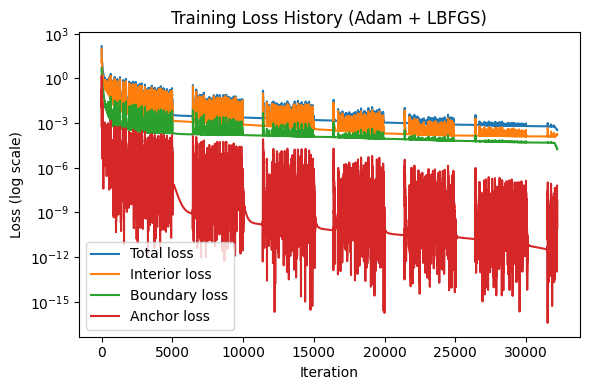

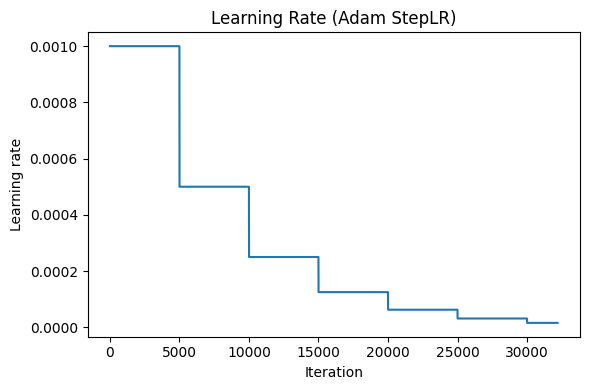

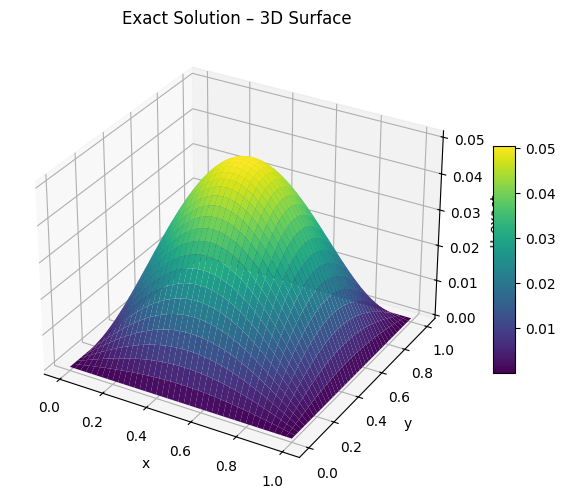

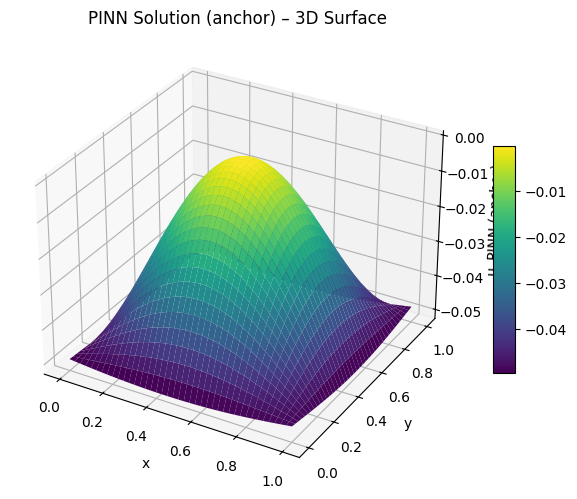

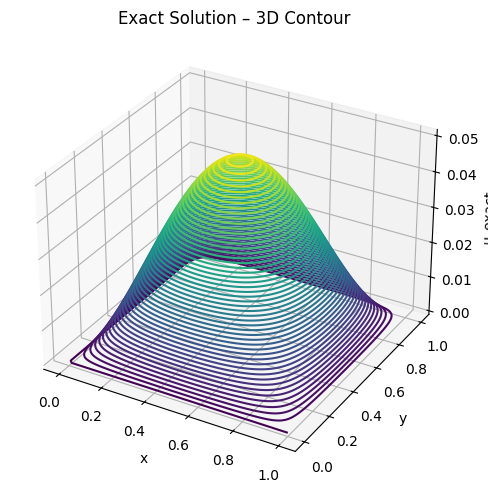

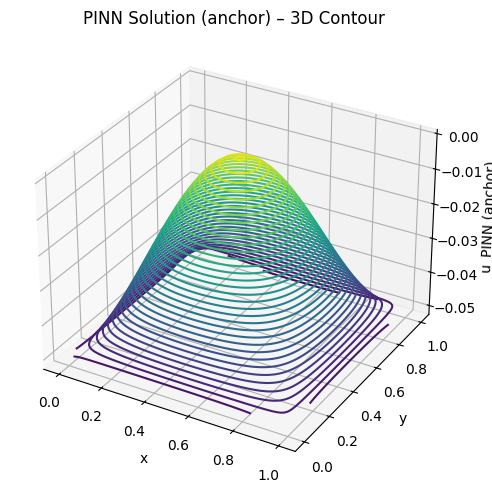

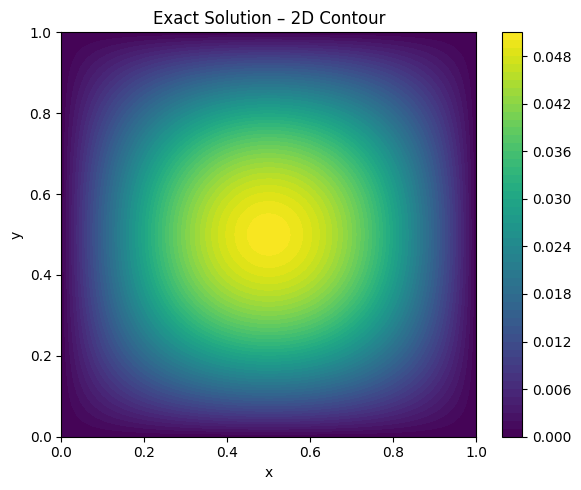

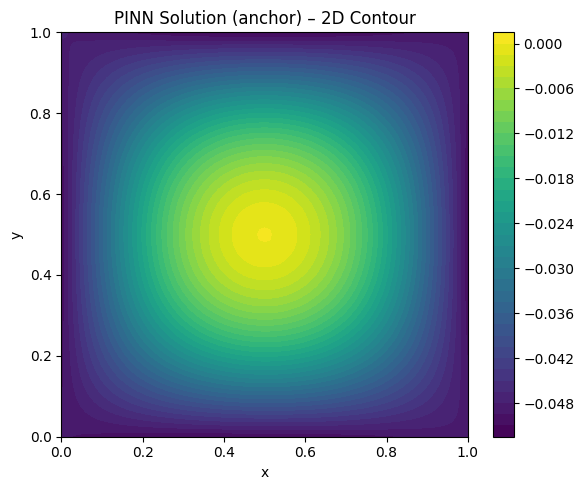


Neural network architecture: FCNet(
  (activation): Tanh()
  (net): Sequential(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=84, bias=True)
    (5): Tanh()
    (6): Linear(in_features=84, out_features=84, bias=True)
    (7): Tanh()
    (8): Linear(in_features=84, out_features=1, bias=True)
  )
)

Training parameters:
  SEED                  = 42
  N_INT (interior)      = 14000
  N_BD_PER_EDGE         = 2100
  total boundary points = 8400
  LAYERS                = [2, 84, 84, 84, 84, 1]
  LR_ADAM               = 0.001
  ADAM_EPOCHS (max)     = 32000
  LR_LBFGS              = 1.0
  LBFGS_STEPS           = 200
  LAMBDA_INT            = 1.0
  LAMBDA_BC             = 10.0
  LAMBDA_ANCHOR         = 10.0
  GRID_N                = 81
  Total parameters      = 21757
  Total training time   = 11908.88 seconds

All results (plots + models) saved i

In [3]:
import os
import time
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =============================================================================
# HYPERPARAMETERS (TUNE IF NEEDED)
# =============================================================================
OUT_DIR          = "p4_example1_anchor_results"
SEED             = 42
TORCH_DTYPE      = torch.float64

# Collocation points
N_INT            = 14000          # interior points
N_BD_PER_EDGE    = 2100           # boundary points per edge (Nb = 4 * N_BD_PER_EDGE)

# Loss weights
LAMBDA_INT       = 1.0
LAMBDA_BC        = 10.0
LAMBDA_ANCHOR    = 10.0           # weight for anchor condition u(x_anchor)=0

# Adam stage
MAX_EPOCHS_ADAM  = 32000
TARGET_LOSS      = 1e-5           # stop if total loss <= TARGET_LOSS
LOG_EVERY        = 500

INIT_LR          = 1e-3
STEP_SIZE_LR     = 5000
GAMMA_LR         = 0.5

# LBFGS refinement
USE_LBFGS        = True
LBFGS_STEPS      = 200             # outer LBFGS steps (max_iter=1 inside)
LBFGS_LR         = 1.0

# Network & evaluation grid
LAYERS           = [2, 84, 84, 84, 84, 1]
GRID_N           = 81
# =============================================================================

torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pi = math.pi

# =============================================================================
# Exact solution for Example 1 (ONLY for generating f, BCs, and evaluation)
#   u(x,y) = 1/(2π²) sin(πx) sin(πy)
#   Δu = - sin(πx) sin(πy)
#   Δ²u = 2π² sin(πx) sin(πy)
# =============================================================================
def u_exact_xy(x, y):
    return (1.0 / (2.0 * pi**2)) * torch.sin(pi * x) * torch.sin(pi * y)

def f_rhs_xy(x, y):
    # Analytic right-hand side f(x,y) = Δ²u_exact
    return 2.0 * (pi**2) * torch.sin(pi * x) * torch.sin(pi * y)

# =============================================================================
# Fully-connected network
# =============================================================================
class FCNet(nn.Module):
    def __init__(self, layers, activation=nn.Tanh()):
        super().__init__()
        self.activation = activation
        net = []
        for i in range(len(layers) - 1):
            net.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                net.append(self.activation)
        self.net = nn.Sequential(*net)

        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# =============================================================================
# Autograd helpers: ∇u, Δu, Δ²u, normal derivatives
# =============================================================================
def laplacian(u, x):
    """
    Compute Δu for u(x) with x in R^2 using autograd.
    """
    grad_u = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]  # (N,2)

    lap = torch.zeros_like(u)
    for i in range(x.shape[1]):
        grad_ui = torch.autograd.grad(
            grad_u[:, i:i+1], x,
            grad_outputs=torch.ones_like(grad_u[:, i:i+1]),
            create_graph=True
        )[0]
        lap = lap + grad_ui[:, i:i+1]
    return lap

def biharmonic(u, x):
    """
    Δ²u = Δ(Δu)
    """
    lap_u = laplacian(u, x)
    bih = laplacian(lap_u, x)
    return bih

def normal_derivative(u, x, normals):
    """
    ∂u/∂n = ∇u · n
    """
    grad_u = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]
    return torch.sum(grad_u * normals, dim=1, keepdim=True)

def normal_derivative_of_laplacian(u, x, normals):
    """
    ∂(Δu)/∂n = ∇(Δu) · n
    """
    lap_u = laplacian(u, x)
    grad_lap = torch.autograd.grad(
        lap_u, x, grad_outputs=torch.ones_like(lap_u), create_graph=True
    )[0]
    return torch.sum(grad_lap * normals, dim=1, keepdim=True)

# =============================================================================
# Collocation sampling
# =============================================================================
def sample_interior(N_int):
    X_int = torch.rand(N_int, 2, device=device)
    X_int.requires_grad_(True)
    return X_int

def sample_boundary(N_bd_per_edge):
    """
    4 edges of [0,1]^2, outward normals:
    left:   (-1, 0)
    right:  ( 1, 0)
    bottom: ( 0,-1)
    top:    ( 0, 1)
    """
    y = torch.rand(N_bd_per_edge, 1, device=device)
    x = torch.rand(N_bd_per_edge, 1, device=device)

    left   = torch.cat([torch.zeros_like(y), y], dim=1)
    right  = torch.cat([torch.ones_like(y),  y], dim=1)
    bottom = torch.cat([x, torch.zeros_like(x)], dim=1)
    top    = torch.cat([x, torch.ones_like(x)], dim=1)

    X_bd = torch.cat([left, right, bottom, top], dim=0)

    n_left   = torch.cat([-torch.ones_like(y), torch.zeros_like(y)], dim=1)
    n_right  = torch.cat([ torch.ones_like(y), torch.zeros_like(y)], dim=1)
    n_bottom = torch.cat([torch.zeros_like(x), -torch.ones_like(x)], dim=1)
    n_top    = torch.cat([torch.zeros_like(x),  torch.ones_like(x)], dim=1)
    normals = torch.cat([n_left, n_right, n_bottom, n_top], dim=0)

    X_bd.requires_grad_(True)
    return X_bd, normals

# =============================================================================
# Boundary data g1, g2 via autograd on u_exact (once, treated as "given BCs")
# =============================================================================
def boundary_data_autograd(X_bd_in, normals_bd):
    """
    For a given exact u, compute:
      g1 = ∂u/∂n,  g2 = ∂(Δu)/∂n  on ∂Ω.
    We do this ONCE and then treat g1,g2 as known boundary data.
    """
    X_bd = X_bd_in.clone().detach().to(device)
    X_bd.requires_grad_(True)

    u_bd_ex = u_exact_xy(X_bd[:, 0:1], X_bd[:, 1:2])
    du_dn_ex   = normal_derivative(u_bd_ex, X_bd, normals_bd)
    dlap_dn_ex = normal_derivative_of_laplacian(u_bd_ex, X_bd, normals_bd)
    return du_dn_ex.detach(), dlap_dn_ex.detach()

# =============================================================================
# Setup network & data
# =============================================================================
os.makedirs(OUT_DIR, exist_ok=True)
print("Using device:", device)
torch.manual_seed(SEED)
np.random.seed(SEED)

net = FCNet(LAYERS).to(device)
print("\nNetwork architecture:\n", net)
print("\nTotal trainable parameters:", count_parameters(net))

# Sample collocation points
X_int_base = sample_interior(N_INT)
X_bd_base, normals_bd = sample_boundary(N_BD_PER_EDGE)

# PDE forcing from analytic f(x,y) (no u_exact in loss)
f_int = f_rhs_xy(X_int_base[:, 0:1], X_int_base[:, 1:2]).detach()

# Boundary data from u_exact via autograd (once; then treated as given)
print("\nComputing (g1, g2) via autograd once ...")
g1_bd, g2_bd = boundary_data_autograd(X_bd_base, normals_bd)

# Anchor point (gauge) - we enforce u(x_anchor, y_anchor) = 0
anchor_point = torch.tensor([[0.5, 0.5]], device=device, dtype=TORCH_DTYPE)
anchor_point.requires_grad_(True)
ANCHOR_VALUE = 0.0

optimizer = torch.optim.Adam(net.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=STEP_SIZE_LR, gamma=GAMMA_LR
)
mse_loss = nn.MSELoss()

loss_history_total  = []
loss_history_int    = []
loss_history_bc     = []
loss_history_anchor = []
lr_history          = []

# =============================================================================
# PINN loss: PDE + boundary + anchor (no exact u in loss)
# =============================================================================
def pinn_loss():
    # reattach grad to coordinates each call
    X_int = X_int_base.clone().detach().requires_grad_(True)
    X_bd  = X_bd_base.clone().detach().requires_grad_(True)

    # Interior: Δ²u = f
    u_int   = net(X_int)
    bih_int = biharmonic(u_int, X_int)
    L_int   = mse_loss(bih_int, f_int)

    # Boundary: ∂u/∂n = g1, ∂(Δu)/∂n = g2
    u_bd    = net(X_bd)
    du_dn   = normal_derivative(u_bd, X_bd, normals_bd)
    dlap_dn = normal_derivative_of_laplacian(u_bd, X_bd, normals_bd)
    L_bc1   = mse_loss(du_dn,   g1_bd)
    L_bc2   = mse_loss(dlap_dn, g2_bd)
    L_bc    = L_bc1 + L_bc2

    # Anchor: u(x_anchor) = 0 (gauge fixing, no constant subtraction)
    u_anchor = net(anchor_point)
    L_anchor = mse_loss(u_anchor, torch.full_like(u_anchor, ANCHOR_VALUE))

    loss = LAMBDA_INT * L_int + LAMBDA_BC * L_bc + LAMBDA_ANCHOR * L_anchor
    return loss, L_int, L_bc, L_anchor

# =============================================================================
# Adam training stage
# =============================================================================
print("\n====================== Adam training (P4, Example 1, anchor) ======================\n")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS_ADAM + 1):
    optimizer.zero_grad()
    loss, L_int, L_bc, L_anchor = pinn_loss()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history_total.append(loss.item())
    loss_history_int.append(L_int.item())
    loss_history_bc.append(L_bc.item())
    loss_history_anchor.append(L_anchor.item())
    lr_history.append(optimizer.param_groups[0]["lr"])

    if epoch == 1 or epoch % LOG_EVERY == 0:
        print(
            f"[Adam] Epoch {epoch:6d} | "
            f"Loss = {loss.item():.4e} | "
            f"L_int = {L_int.item():.4e} | "
            f"L_bc = {L_bc.item():.4e} | "
            f"L_anchor = {L_anchor.item():.4e} | "
            f"LR = {optimizer.param_groups[0]['lr']:.3e}"
        )

    if loss.item() <= TARGET_LOSS:
        print(f"\nTarget loss {TARGET_LOSS:.1e} reached at epoch {epoch}. Stopping Adam.")
        break

# =============================================================================
# LBFGS refinement stage
# =============================================================================
if USE_LBFGS:
    print("\n====================== LBFGS refinement (anchor gauge) ======================\n")
    lbfgs = torch.optim.LBFGS(
        net.parameters(),
        lr=LBFGS_LR,
        max_iter=1,               # one internal step per outer iteration
        history_size=50,
        line_search_fn="strong_wolfe"
    )

    for i in range(1, LBFGS_STEPS + 1):
        def closure():
            lbfgs.zero_grad()
            loss, L_int, L_bc, L_anchor = pinn_loss()
            loss.backward()
            return loss

        loss = lbfgs.step(closure)
        loss, L_int, L_bc, L_anchor = pinn_loss()

        # also append to history so plots include LBFGS stage
        loss_history_total.append(loss.item())
        loss_history_int.append(L_int.item())
        loss_history_bc.append(L_bc.item())
        loss_history_anchor.append(L_anchor.item())
        lr_history.append(lr_history[-1])  # LR constant during LBFGS

        print(
            f"[LBFGS] Step {i:3d} | "
            f"Loss = {loss.item():.4e} | "
            f"L_int = {L_int.item():.4e} | "
            f"L_bc = {L_bc.item():.4e} | "
            f"L_anchor = {L_anchor.item():.4e}"
        )

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal training time (Adam + LBFGS): {training_time:.2f} seconds.")

# =============================================================================
# Save model
# =============================================================================
os.makedirs(OUT_DIR, exist_ok=True)
state_path = os.path.join(OUT_DIR, "p4_example1_pinn_anchor_state_dict.pth")
full_path  = os.path.join(OUT_DIR, "p4_example1_pinn_anchor_full.pth")
torch.save(net.state_dict(), state_path)
torch.save(net, full_path)
print("\nSaved model state_dict to:", state_path)
print("Saved full model to:", full_path)

# =============================================================================
# Evaluation (NO constant subtraction; anchor has fixed the gauge)
# We use u_exact ONLY for computing error metrics.
# =============================================================================
print("\n====================== Evaluating on dense grid (no constant subtraction) ======================\n")

xs = torch.linspace(0.0, 1.0, GRID_N, device=device)
ys = torch.linspace(0.0, 1.0, GRID_N, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing="ij")
XY = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)
XY.requires_grad_(True)

# Predicted & exact
u_pred = net(XY)
u_ex   = u_exact_xy(XY[:, 0:1], XY[:, 1:2])

# Gradients
grad_pred = torch.autograd.grad(
    u_pred, XY, grad_outputs=torch.ones_like(u_pred), create_graph=True
)[0]
grad_ex = torch.autograd.grad(
    u_ex, XY, grad_outputs=torch.ones_like(u_ex), create_graph=True
)[0]

# Laplacians
lap_pred = laplacian(u_pred, XY)
lap_ex   = laplacian(u_ex,   XY)

# Errors
e      = u_pred - u_ex
grad_e = grad_pred - grad_ex
lap_e  = lap_pred - lap_ex

def L2_from_field(field):
    return torch.sqrt(torch.mean(field**2))

# Norms of exact solution
L2_u      = L2_from_field(u_ex)
L2_grad_u = L2_from_field(grad_ex[:, 0:1]) + L2_from_field(grad_ex[:, 1:2])
L2_lap_u  = L2_from_field(lap_ex)

# Norms of error
L2_e      = L2_from_field(e)
L2_grad_e = L2_from_field(grad_e[:, 0:1]) + L2_from_field(grad_e[:, 1:2])
L2_lap_e  = L2_from_field(lap_e)

# Relative errors (as in your PDF style)
L2_rel = (L2_e / L2_u).item()
H1_rel = ((L2_e + L2_grad_e) / (L2_u + L2_grad_u)).item()
H2_rel = ((L2_e + L2_grad_e + L2_lap_e) / (L2_u + L2_grad_u + L2_lap_u)).item()

print("Relative error metrics (anchor gauge, NO constant subtraction):")
print(f"  L2  relative error        ≈ {L2_rel:.4e}")
print(f"  H1  energy relative error ≈ {H1_rel:.4e}")
print(f"  H2  energy relative error ≈ {H2_rel:.4e}")

print("\nAbsolute norms (for reference):")
print(f"  ||e||_L2      ≈ {L2_e.item():.4e}")
print(f"  ||∇e||_L2     ≈ {L2_grad_e.item():.4e}")
print(f"  ||Δe||_L2     ≈ {L2_lap_e.item():.4e}")

# =============================================================================
# Plots: loss, LR, 3D/2D surfaces & contours
# =============================================================================
epochs_range = np.arange(1, len(loss_history_total) + 1)

# Loss history
plt.figure(figsize=(6, 4))
plt.semilogy(epochs_range, loss_history_total, label="Total loss")
plt.semilogy(epochs_range, loss_history_int,   label="Interior loss")
plt.semilogy(epochs_range, loss_history_bc,    label="Boundary loss")
plt.semilogy(epochs_range, loss_history_anchor, label="Anchor loss")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss History (Adam + LBFGS)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_history_anchor.png"), dpi=300)
plt.show()

# LR history
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, lr_history[:len(epochs_range)])
plt.xlabel("Iteration")
plt.ylabel("Learning rate")
plt.title("Learning Rate (Adam StepLR)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lr_history_anchor.png"), dpi=300)
plt.show()

# Prepare grids for solution plots
U_exact_grid = u_ex.detach().cpu().numpy().reshape(GRID_N, GRID_N)
U_pred_grid  = u_pred.detach().cpu().numpy().reshape(GRID_N, GRID_N)
X_plot       = Xg.detach().cpu().numpy()
Y_plot       = Yg.detach().cpu().numpy()

# 3D surfaces
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
surf1 = ax.plot_surface(X_plot, Y_plot, U_exact_grid, cmap="viridis")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("u_exact")
ax.set_title("Exact Solution – 3D Surface")
fig.colorbar(surf1, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_3d_surface.png"), dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
surf2 = ax.plot_surface(X_plot, Y_plot, U_pred_grid, cmap="viridis")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("u_PINN (anchor)")
ax.set_title("PINN Solution (anchor) – 3D Surface")
fig.colorbar(surf2, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_3d_surface_anchor.png"), dpi=300)
plt.show()

# 3D contours
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.contour3D(X_plot, Y_plot, U_exact_grid, 50, cmap="viridis")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("u_exact")
ax.set_title("Exact Solution – 3D Contour")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_3d_contour.png"), dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.contour3D(X_plot, Y_plot, U_pred_grid, 50, cmap="viridis")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("u_PINN (anchor)")
ax.set_title("PINN Solution (anchor) – 3D Contour")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_3d_contour_anchor.png"), dpi=300)
plt.show()

# 2D contours
plt.figure(figsize=(6, 5))
cf1 = plt.contourf(X_plot, Y_plot, U_exact_grid, levels=50)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Exact Solution – 2D Contour")
plt.colorbar(cf1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_2d_contour.png"), dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
cf2 = plt.contourf(X_plot, Y_plot, U_pred_grid, levels=50)
plt.xlabel("x"); plt.ylabel("y")
plt.title("PINN Solution (anchor) – 2D Contour")
plt.colorbar(cf2)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_2d_contour_anchor.png"), dpi=300)
plt.show()

print("\nNeural network architecture:", net)
print("\nTraining parameters:")
print(f"  SEED                  = {SEED}")
print(f"  N_INT (interior)      = {N_INT}")
print(f"  N_BD_PER_EDGE         = {N_BD_PER_EDGE}")
print(f"  total boundary points = {4 * N_BD_PER_EDGE}")
print(f"  LAYERS                = {LAYERS}")
print(f"  LR_ADAM               = {INIT_LR}")
print(f"  ADAM_EPOCHS (max)     = {MAX_EPOCHS_ADAM}")
print(f"  LR_LBFGS              = {LBFGS_LR}")
print(f"  LBFGS_STEPS           = {LBFGS_STEPS}")
print(f"  LAMBDA_INT            = {LAMBDA_INT}")
print(f"  LAMBDA_BC             = {LAMBDA_BC}")
print(f"  LAMBDA_ANCHOR         = {LAMBDA_ANCHOR}")
print(f"  GRID_N                = {GRID_N}")
print(f"  Total parameters      = {count_parameters(net)}")
print(f"  Total training time   = {training_time:.2f} seconds")
print("\nAll results (plots + models) saved in:", OUT_DIR)
